<a href="https://colab.research.google.com/github/rikanga/Easy-Numpy/blob/main/06_algorithm_chains_and_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from preamble import *
# %matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
!pip install mglearn
import mglearn

     |████████████████████████████████| 540 kB 26.7 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=68f6099cb7c2cf278e7ca63415cdaa26217cd6a4f854c7a127449a04d52af391
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


## Algorithm Chains and Pipelines

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
cancer = load_breast_cancer()

In [4]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   random_state=0)

In [5]:
# compute minimum and maximum in the training set
scaler = MinMaxScaler().fit(X_train)

In [6]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:
# Building the SVC model
svc = SVC()
svc.fit(X_train_scaled, y_train)

SVC()

In [8]:
print("Test score: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Test score: 0.972


### **Parameter Selection with Preprocessing**

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [11]:
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)

In [12]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [13]:
print("Best cross-validaton score! {:.3f}".format(grid.best_score_))
print("Best set score {:.3f}".format(grid.score(X_test_scaled, y_test)))
print("Best paramater {}".format(grid.best_params_))

Best cross-validaton score! 0.981
Best set score 0.972
Best paramater {'C': 1, 'gamma': 1}


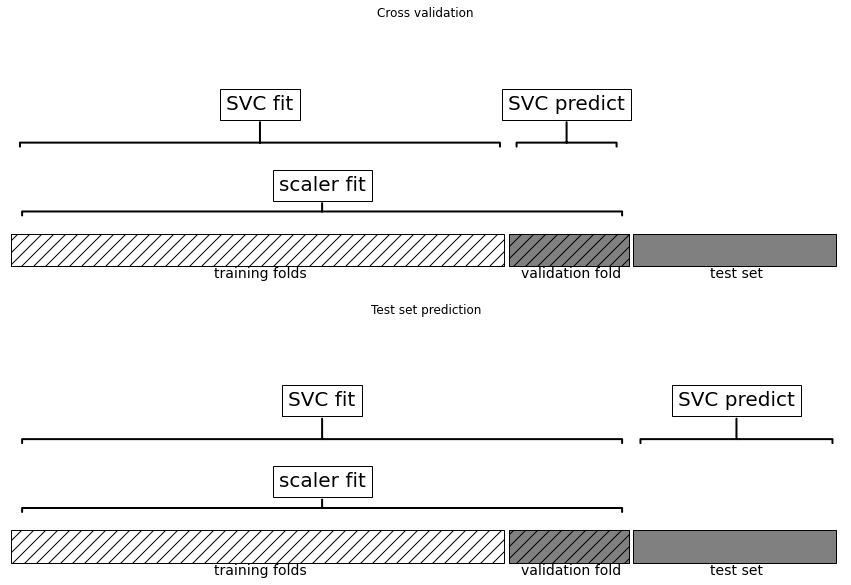

In [14]:
mglearn.plots.plot_improper_processing()

### **Building Pipelines**

Le Pipiline est une classe qui permet le collage de plusieurs étapes de traitement des estimateurs sklearn en une seule étape.

Il contient aussi les methodes, fit, predict et score.

Le principale usage de Pipeline est le pré-traitement de données enchaîné avec le classificateur

In [15]:
from sklearn.pipeline import Pipeline

In [16]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC())])

Ici nous avons créé deux étapes:
* 'scaler' qui est une instance de MinMaxScler et 
* 'svc' qui est une instance de SVC()

In [17]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svc', SVC())])

Ici la methode **fit** est deux fois utilisée:
* D'abord pour s'entrainer les données dans **scaler** qui fait donne leur pré-traitement
* Et dans dans **svc** qui récoit les données pré-traitées.

In [18]:
print("Test score: {:.3f}".format(pipe.score(X_test, y_test)))

Test score: 0.972


Ici aussi, en appele la methode **score**, d'abord **scaler** qui fait le pré-traitement de test set et puis on appele enfin la methode **score** de svc qui nous donne sa performance

### **Using Pipelines in Grid Searches**

In [19]:
param_grid = {
    "svc__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [20]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [21]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [22]:
print("Best cross-validation sccuracy: {:.3f}".format(grid.best_score_))
print("Best Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("Best parameter: {}".format(grid.best_params_))

Best cross-validation sccuracy: 0.981
Best Test set score: 0.972
Best parameter: {'svc__C': 1, 'svc__gamma': 1}


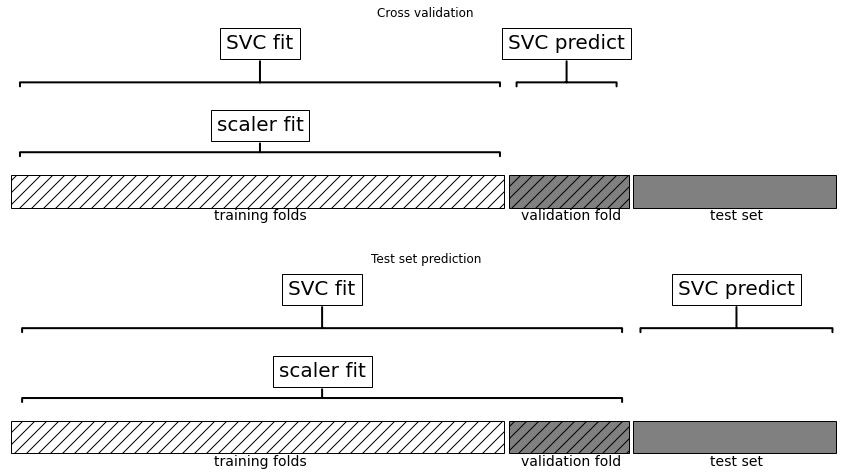

In [23]:
mglearn.plots.plot_proper_processing()

### **Illustrating Information Leakage**

Fuite d'informations dans la validation croisée.

La fuite d'information dans la validation croisée varie en fonction de l'étape de pré-traitement

In [24]:
rnd = np.random.RandomState(seed=0)

In [25]:
X = rnd.normal(size=(100, 1000))
y = rnd.normal(size=(100,))

**Selecting the most informative features**

In [26]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [27]:
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [29]:
X_selected = select.transform(X)

In [30]:
X_selected.shape, y.shape

((100, 50), (100,))

In [31]:
np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))

0.345477308247069

In [32]:
#Test with pipeline
pipe = Pipeline([
    ('select', SelectPercentile(score_func=f_regression, percentile=5)),
    ('riddge', Ridge())
])

In [33]:
pipe.fit(X_selected, y)

Pipeline(steps=[('select',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_regression at 0x7f33fbfad320>)),
                ('riddge', Ridge())])

In [34]:
np.mean(cross_val_score(pipe, X, y, cv=5))

-0.7849991501567429

## **The General Pipeline Interface**

### **Convenient Pipeline Creation with make_pipeline**

**Creation pratique de pipeline avec make_pipeline**

C'est une façon un peu plus rapide de créer des pipeline sans toute fois décrire la classe ou le classificateur sauf juste l'instancier.

On y arrive grâce à la fonction **make_pipeline** du module sklearn **pipeline**

In [35]:
from sklearn.pipeline import make_pipeline

In [36]:
# Standard synthax
pipe_long = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(C=100))
])

# Abreviated synthax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [37]:
# steps with Standard synthax
pipe_long.steps

[('scaler', MinMaxScaler()), ('svc', SVC(C=100))]

In [38]:
# steps with Abreviated synthax
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

**Multiple steps**

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [40]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.fit(cancer.data)

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('standardscaler-2', StandardScaler())])

In [41]:
# Pipe steps
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

### **Accessing Step Attributes**

Pour accèder aux étapes dans le pipeline, on utiliser, l'attribut **named_steps**

In [42]:
components = pipe.named_steps["pca"].components_

In [43]:
print("Components.shape {}".format(components.shape))

Components.shape (2, 30)


In [44]:
cancer.data.shape

(569, 30)

### **Accessing Attributes in a Grid-Searched Pipeline**

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [47]:
param_grid = {'logisticregression__C':[0.01, 0.1, 1, 10, 100],
             'logisticregression__max_iter':[10000]}

In [48]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   random_state=4)

In [49]:
grid = GridSearchCV(pipe, param_grid, cv=5)

In [50]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'logisticregression__max_iter': [10000]})

In [51]:
print("Best estimator: \n{}".format(grid.best_estimator_))

Best estimator: 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=10000))])


**Get to pipeline steps**

In [52]:
grid.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.43570655, -0.34266946, -0.40809443, -0.5344574 , -0.14971847,
         0.61034122, -0.72634347, -0.78538827,  0.03886087,  0.27497198,
        -1.29780109,  0.04926005, -0.67336941, -0.93447426, -0.13939555,
         0.45032641, -0.13009864, -0.10144273,  0.43432027,  0.71596578,
        -1.09068862, -1.09463976, -0.85183755, -1.06406198, -0.74316099,
         0.07252425, -0.82323903, -0.65321239, -0.64379499, -0.42026013]])

### **Grid-Searching Preprocessing Steps and Model Parameters**

In [53]:
from sklearn.datasets import load_boston

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                  random_state=0)

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)

In [59]:
pipe.steps

[('standardscaler', StandardScaler()),
 ('polynomialfeatures', PolynomialFeatures()),
 ('ridge', Ridge())]

In [60]:
param_grid = {
    'polynomialfeatures__degree':[1, 2, 3],
    'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]
}

In [61]:
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [62]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [63]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=10))])

**Evaluation de resultats de la validation croisée**

Nous allons parcourir l'attribut **cv_results_** qui est un dictionnaire contenant différentes clés

In [64]:
grid.cv_results_

{'mean_fit_time': array([0.00297532, 0.00273137, 0.00252743, 0.00232849, 0.00343661,
        0.00372348, 0.00545402, 0.00457735, 0.00901175, 0.00638561,
        0.01114278, 0.01072044, 0.03478675, 0.02282686, 0.01717887,
        0.0210073 , 0.01773143, 0.01813784]),
 'mean_score_time': array([0.00089002, 0.00088825, 0.00087261, 0.00085778, 0.00129299,
        0.00101328, 0.00437632, 0.00385485, 0.00281672, 0.00510955,
        0.00276222, 0.0012043 , 0.00520883, 0.00269294, 0.00456419,
        0.00190639, 0.00442605, 0.00691066]),
 'mean_test_score': array([ 7.21915761e-01,  7.21919281e-01,  7.21954085e-01,  7.22265610e-01,
         7.23325945e-01,  7.07951636e-01,  7.60170834e-01,  7.59448408e-01,
         7.66651449e-01,  7.94966818e-01,  8.28726141e-01,  8.04832665e-01,
        -5.81095202e+02, -1.60898751e+02, -1.31972858e+01, -3.17933469e-02,
         6.48340571e-01,  6.54083028e-01]),
 'param_polynomialfeatures__degree': masked_array(data=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3,

In [65]:
cv_results = grid.cv_results_['mean_test_score']

In [66]:
cv_results

array([ 7.21915761e-01,  7.21919281e-01,  7.21954085e-01,  7.22265610e-01,
        7.23325945e-01,  7.07951636e-01,  7.60170834e-01,  7.59448408e-01,
        7.66651449e-01,  7.94966818e-01,  8.28726141e-01,  8.04832665e-01,
       -5.81095202e+02, -1.60898751e+02, -1.31972858e+01, -3.17933469e-02,
        6.48340571e-01,  6.54083028e-01])

In [67]:
cv_results.reshape(3, -1).shape

(3, 6)

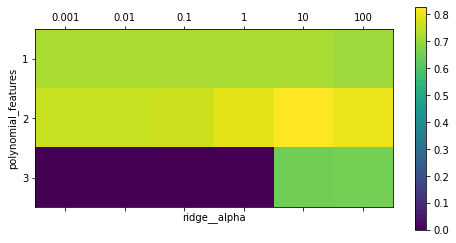

In [68]:
plt.matshow(cv_results.reshape(3, -1), vmin=0, cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomial_features")

plt.xticks(range(len(param_grid['ridge__alpha'])),
           param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])
plt.colorbar()
plt.show()

On peut voir qu'avec PolynomialFeatures de degré 2 on atteint une bonne performance mais pire performances avec le degré 1 et 3

In [69]:
print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))

Test set score: 0.768


In [70]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [71]:
# Run withour polynomial features
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

pipe = make_pipeline(StandardScaler(), Ridge())

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


On obtient une précision faible contrairement à lorsque l'on utilise **PolynomialFeatures**

## **Grid-Searching Which Model To Use**

In [82]:
pipe  = Pipeline([
                  ('preprocessing', StandardScaler()),
                  ('classifier', SVC())
])

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
RandomForestClassifier?

In [85]:
param_grid = [
{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},

{'classifier': [RandomForestClassifier(n_estimators=100)],
'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)

In [87]:
grid = GridSearchCV(pipe, param_grid, cv=5)

In [88]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10, gamma=0.01)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler(), None]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])

In [89]:
grid.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', SVC(C=10, gamma=0.01))])

Nous voyons que de deux modèle proposés, le modèle qui donnerai de bonne performance est SVC

In [90]:
grid.score(X_test, y_test)

0.9790209790209791